### Let's explore the data

Inspired by "Feature engineering, xgboost" kernel by Denis Larionov

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sales = pd.read_csv('../data/sales_train_v2.csv')

item_cat = pd.read_csv('../data/item_categories.csv')
sub = pd.read_csv("../data/sample_submission.csv")
shops = pd.read_csv("../data/shops.csv")
item = pd.read_csv("../data/items.csv")
test = pd.read_csv("../data/test.csv").set_index('ID')

In [3]:
sales.head(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
5,10.01.2013,0,25,2564,349.00,1.0
6,02.01.2013,0,25,2565,549.00,1.0
7,04.01.2013,0,25,2572,239.00,1.0
8,11.01.2013,0,25,2572,299.00,1.0
9,03.01.2013,0,25,2573,299.00,3.0


**Quick observation**: Probably it is a good thing convert the date column to datetime, so let's do it.

In [4]:
import datetime

sales.date = sales.date.apply(lambda x: datetime.datetime.strptime(x, '%d.%m.%Y'))

sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


### Data Exploration

Firstly, let's look for noisy values.

In [5]:
print('Max number of sales in a day: {0}'.format(sales.item_cnt_day.max()))
print('Min number of sales in a day: {0}'.format(sales.item_cnt_day.min()))

Max number of sales in a day: 2169.0
Min number of sales in a day: -22.0


In [6]:
print('Max price: {0}'.format(sales.item_price.max()))
print('Min price: {0}'.format(sales.item_price.min()))

Max price: 307980.0
Min price: -1.0


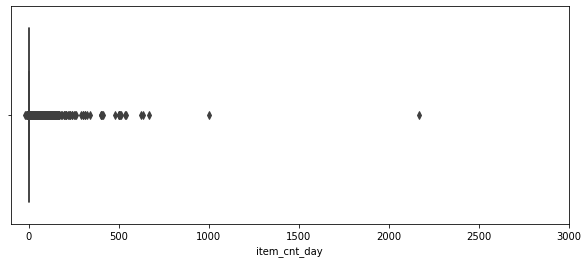

In [7]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=sales.item_cnt_day)

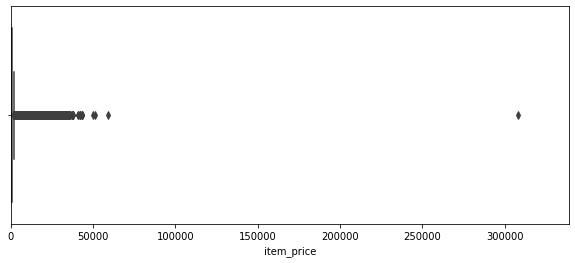

In [8]:
plt.figure(figsize=(10,4))
plt.xlim(sales.item_price.min(), sales.item_price.max()*1.1)
sns.boxplot(x=sales.item_price)

**Quick observation**: Clearly we can find some outliers. I will replace those strage values with the median of those products in other stores.

In [9]:
sales.loc[sales['item_price'] > 300000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,2013-12-13,11,12,6066,307980.0,1.0


In [10]:
sales.loc[sales['item_id'] == 6066].shape

(1, 6)

In [11]:
sales.loc[sales['item_cnt_day'] > 1000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2909818,2015-10-28,33,12,11373,0.908714,2169.0


In [12]:
sales.loc[sales['item_id'] == 11373].shape

(464, 6)

There is only one value with exorbitant price, so I'll exclude it. Otherwise, there is some values with same id of the item with the maximum item_cnt_day, thus I'll fill it with the median of the values in the other stores.

In [13]:
sales = sales[sales['item_price'] < 100000]

In [14]:
median = sales[sales['item_id'] == 11373]['item_cnt_day'].median()
sales.loc[sales['item_cnt_day'] > 1000, 'item_cnt_day'] = median
median

4.0

There is one item with price below zero. I'll fill it with the median. The item_cnt_days with negative values I'll assume that those are goods return.

In [15]:
sales.loc[sales['item_price'] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,2013-05-15,4,32,2973,-1.0,1.0


In [16]:
median = sales[sales['item_id'] == 2973]['item_price'].median()
sales.loc[sales['item_price'] < 0, 'item_price'] = median
median

2499.0

**Observation**: Each shop_name starts with the city name. Given that, it's created a feature called "city_code" which represents the encoded label (City converted to number), respectively.

Additionaly, there's is some city names with typo such as Сергиев Посад ТЦ "7Я" and "!Якутск".

In [17]:
from sklearn.preprocessing import LabelEncoder

shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]
shops.head(10)

,shop_id,city_code
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2
5,5,3
6,6,4
7,7,4
8,8,4
9,9,5


**Observation**: Each category contains type and subtype in its name. 

In [33]:
item_cat['split'] = item_cat['item_category_id'].str.split('-')
item_cat['type'] = item_cat['split'].map(lambda x: x[0].strip())
item_cat['type_code'] = LabelEncoder().fit_transform(item_cat['type'])

# In case subtype is nan then type

item_cat['subtype'] = item_cat['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
item_cat['subtype_code'] = LabelEncoder().fit_transform(item_cat['subtype'])
item_cat = item_cat[['item_category_id','type_code', 'subtype_code']]

items.drop(['item_name'], axis=1, inplace=True)

AttributeError: Can only use .str accessor with string values!